In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '..//')

import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

from src.models import thermal_model
from src.common import functions, enums, schema
from src.data import source


In [4]:
PATH_GB_DATA = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\00 - Final data\Annual_demand')
PATH_CIBSE_DATA = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\data\CIBSE weather data\WD16SET\WD16SET\WDD16SET\WDD16SET\WMD16SET\WMD16SET")

In [5]:
# Parameters 
path_results_simulation:Path = Path().absolute().parent/"data"/"results"
path_results_simulation.mkdir(parents=True, exist_ok=True)
target_year:int = 2022
solar_gains = True 
timestep:int = 3600 #seconds

HDD_ref_temperature:float = 15.5
CDD_ref_temperature:float = 24

path_export_netcdf_results:Path = Path().absolute().parent/"data"
path_thermal_data = PATH_GB_DATA/'Thermal_characteristics_afterEE.csv'
residential_data = pd.read_csv(path_thermal_data, index_col=0)
residential_data.head()

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC
Index,,,,,,,,,,,,
0,S01006506,aberdeen city,North East Scotland,detached,gas boiler,43906.250000,0.273266,102.0,17533.867465,175.625000,medium,-5.0
1,S01006506,aberdeen city,North East Scotland,detached,oil boiler,66000.000000,0.299051,12.0,19188.338395,264.000000,medium,-5.0
2,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,66187.500000,0.390676,1.0,25067.327542,264.750000,medium,-5.0
3,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,27846.153846,0.216864,60.0,13914.831788,111.384615,medium,-5.0
4,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,22055.555556,0.113292,2.0,7269.253731,88.222222,medium,-5.0


In [6]:
list_las = residential_data["Local Authority"].unique()
len(list_las)

380

In [7]:
# last_df = functions.create_dd_dataframes_for_all_LAs(list_las, path_export_netcdf_results, HDD_ref_temperature, CDD_ref_temperature)
# last_df

In [8]:

external_data = pd.read_csv(path_export_netcdf_results/"raw"/f"{LA_str}_degree_days.csv".replace(" ", "_"), index_col=0, parse_dates=True)
external_data.head()

NameError: name 'LA_str' is not defined

In [32]:
LA_str = "Cardiff"
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = Path(PATH_CIBSE_DATA).rglob('Cardiff_DSY2_2050High50*.csv')

list_files = []
for path in pathlist:
  print(path.stem)
  list_files.append(path.stem)
  temp_dataf = pd.read_csv(path, skiprows=32, header=None, delimiter=",", names=column_names)

Cardiff_DSY2_2050High50_


In [48]:
external_data = temp_dataf.rename(columns={'GSR':schema.DataSchema.SOLARRADIATION, 'DBT': schema.DataSchema.OAT})
external_data['index'] = pd.to_datetime(external_data[['Year', 'Month', 'Day', 'Hour']])
external_data = external_data.set_index('index')
external_data.head()

,Year,Month,Day,Hour,PWC,Cloud,Outdoor_air_temperature_(degreeC),WBT,RH,Press,...,Solar_radiation(W/m2),DSR,Alt,Dec,Cloud1,DBT1,WBT1,Press1,WD1,WS1
index,,,,,,,,,,,,,,,,,,,,,
2050-01-01 01:00:00,2050,1,1,1,-999,6,9.5,8.6,89,994.0,...,0,0,-61.5,-23.0,0,0,0,0,0,0
2050-01-01 02:00:00,2050,1,1,2,-999,4,9.5,8.6,89,994.9,...,0,0,-58.3,-23.0,0,0,0,0,0,0
2050-01-01 03:00:00,2050,1,1,3,23,3,9.4,8.4,87,995.7,...,0,0,-51.8,-23.0,0,0,0,0,0,0
2050-01-01 04:00:00,2050,1,1,4,-999,6,9.5,8.5,88,996.9,...,0,0,-43.5,-23.0,0,0,0,0,0,0
2050-01-01 05:00:00,2050,1,1,5,81,7,9.5,8.5,88,997.5,...,0,0,-34.4,-23.0,0,0,0,0,0,0


In [52]:
LA_str  = "Cardiff"
filt = (residential_data["Local Authority"]==LA_str) & (residential_data["Thermal capacity level"]=="medium")
LA_residential_data = residential_data.loc[filt, :]
data_source = source.SimulationData(external_data)
sim_dataf = data_source.create_CIBSE_based_simulation_data()

row = LA_residential_data.iloc[0]
results_df = functions.run_simulation(sim_dataf.copy(), row, initial_indoor_air_temperature=21)
results_df

,Average_indoor_air_temperature_(degreeC),Outdoor_air_temperature_(degreeC),Heating_output_(kW),Solar_radiation(W/m2),Solar_gains_(kW),Occupancy_gains_(kW),Appliances_gains_(kW),Total_gains_(kW),Internal_heat_gains_(kW),Heating_season_flag,Ventilation_losses_(kW)
Time_(h),,,,,,,,,,,
0,21.000000,9.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3600,20.440995,9.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.117653
7200,19.909162,9.4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.014715
10800,19.398321,9.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.935196
14400,18.917172,9.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.822714
...,...,...,...,...,...,...,...,...,...,...,...
31518000,13.196827,12.7,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.018741
31521600,13.172677,12.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.091488
31525200,13.139978,12.3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.123869


<AxesSubplot: xlabel='Time_(h)'>

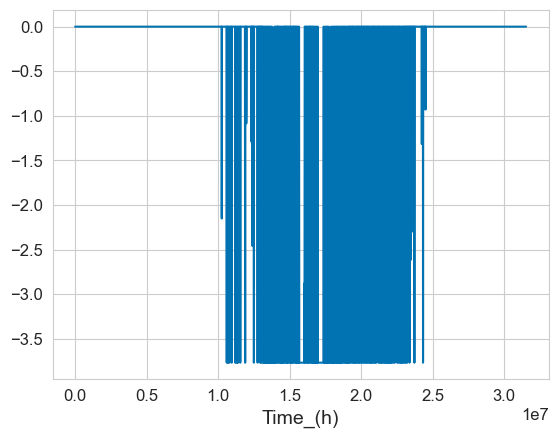

In [54]:
results_df[schema.DataSchema.HEATINGOUTPUT].plot()

<AxesSubplot: xlabel='Time_(h)'>

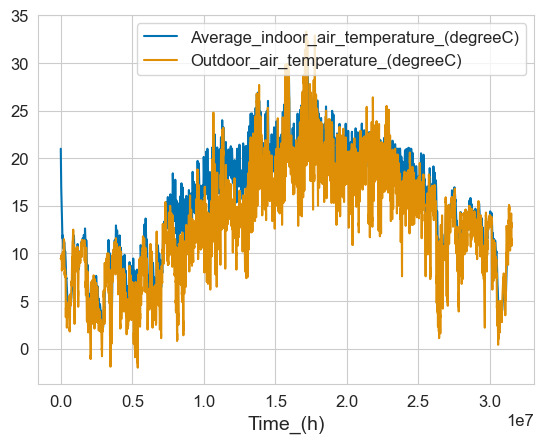

In [53]:
results_df[[schema.DataSchema.IAT,schema.DataSchema.OAT]].plot()

In [55]:
for LA_str in ["Cardiff"]:#list_las[:1]:
    print(LA_str)
    # Load outdoor air temperature and solar radiation data for the local authority
    # external_data = pd.read_csv(path_export_netcdf_results/"raw"/f"{LA_str}_degree_days.csv".replace(" ", "_"), index_col=0, parse_dates=True)
    # external_data.fillna(0, inplace=True)
    filt = (residential_data["Local Authority"]==LA_str) & (residential_data["Thermal capacity level"]=="medium")
    LA_residential_data = residential_data.loc[filt, :]
    nb_dwellings = LA_residential_data["Number of dwellings"]
    data_source = source.SimulationData(external_data)
    sim_dataf = data_source.create_CIBSE_based_simulation_data()
    temp_LA_results = LA_residential_data.apply(
                                        lambda row: functions.run_simulation(
                                        sim_dataf.copy(), 
                                        row,
                                        initial_indoor_air_temperature=21), axis=1, result_type="expand")
    temp_LA_results.columns = [schema.ResultSchema.SPECIFICHEATINGDEMAND, schema.ResultSchema.SPECIFICCOOLINGDEMAND]
    temp_LA_results[[schema.ResultSchema.HEATINGDEMAND, schema.ResultSchema.COOLINGDEMAND]] = temp_LA_results.mul(nb_dwellings, axis=0)
    temp_LA_results[schema.ResultSchema.YEAR] = target_year
    temp_LA_results.index.name = "Index"

Cardiff
heating demand 0.0kWh and cooling demand is -5822.234274263647kWh
heating demand 0.0kWh and cooling demand is -3206.249766759007kWh
heating demand 0.0kWh and cooling demand is -4061.5229891231274kWh
heating demand 0.0kWh and cooling demand is -2278.878504220971kWh
heating demand 0.0kWh and cooling demand is -4378.26077150845kWh
heating demand 0.0kWh and cooling demand is -1842.2416208414502kWh
heating demand 0.0kWh and cooling demand is -4147.6857684718825kWh
heating demand 0.0kWh and cooling demand is -2286.452071811961kWh
heating demand 0.0kWh and cooling demand is -1337.8673340952032kWh
heating demand 0.0kWh and cooling demand is -3631.078210459618kWh
heating demand 0.0kWh and cooling demand is -5822.234274263647kWh
heating demand 0.0kWh and cooling demand is -2852.3115360996853kWh
heating demand 0.0kWh and cooling demand is -2278.878504220971kWh
heating demand 0.0kWh and cooling demand is -4522.589139794045kWh
heating demand 0.0kWh and cooling demand is -2494.3368200844197k

In [57]:
temp_concat_results = pd.concat([LA_residential_data, temp_LA_results], axis=1)
temp_concat_results.head()

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,Specific heating demand (kWh/dwelling),Specific cooling demand (kWh/dwelling),Heating demand (kWh),Cooling demand (kWh),Year
Index,,,,,,,,,,,,,,,,,
406262,W01001694,Cardiff,Wales,detached,gas boiler,33083.123852,0.269136,23.0,13298.964256,132.332495,medium,-3.0,0.0,-5822.234274,0.0,-1.339114e+05,2022
406263,W01001694,Cardiff,Wales,detached,resistance heating,24853.138514,0.072964,5.0,3605.426575,99.412554,medium,-3.0,0.0,-3206.249767,0.0,-1.603125e+04,2022
406264,W01001694,Cardiff,Wales,semi-detached,gas boiler,23154.761905,0.183616,44.0,9073.148148,92.619048,medium,-3.0,0.0,-4061.522989,0.0,-1.787070e+05,2022
406265,W01001694,Cardiff,Wales,semi-detached,resistance heating,13957.389286,0.074805,3.0,3696.381947,55.829557,medium,-3.0,0.0,-2278.878504,0.0,-6.836636e+03,2022
406266,W01001694,Cardiff,Wales,terraced,gas boiler,24819.962687,0.205505,446.0,10154.740188,99.279851,medium,-3.0,0.0,-4378.260772,0.0,-1.952704e+06,2022


In [58]:
cooling_per_m2 = schema.ResultSchema.SPECIFICCOOLINGDEMAND.replace("kWh/dwelling", "kWh/m2")
temp_concat_results[cooling_per_m2] = temp_concat_results[schema.ResultSchema.SPECIFICCOOLINGDEMAND]/temp_concat_results["Average floor area m2"]
temp_concat_results[cooling_per_m2]

Index
406262   -43.997011
406263   -32.251961
406264   -43.851919
406265   -40.818495
406266   -44.100195
            ...    
408488   -35.420580
408489   -44.849022
408490   -35.193561
408491   -43.679816
408492   -27.932479
Name: Specific cooling demand (kWh/m2), Length: 1737, dtype: float64

In [59]:
nb_dwellings = temp_concat_results["Number of dwellings"].sum()
total_floor_area = temp_concat_results["Average floor area m2"].sum()*nb_dwellings
print(f"In {LA_str}, there are {nb_dwellings:,.0f} dwellings for a total floor area of {total_floor_area/1_000_000:,.0f} km2")

In Cardiff, there are 144,220 dwellings for a total floor area of 22,501 km2


<AxesSubplot: xlabel='Dwelling forms'>

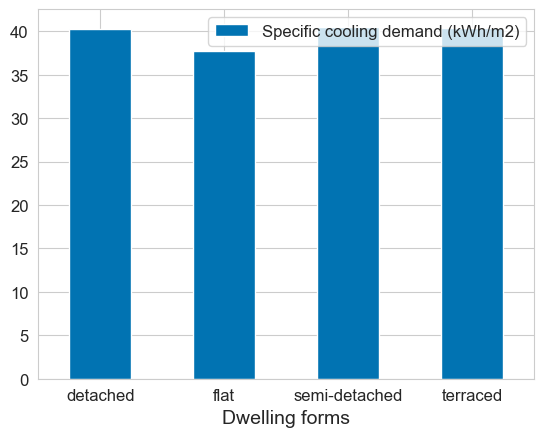

In [60]:
(-temp_concat_results.groupby("Dwelling forms").agg({cooling_per_m2:"mean"})).plot.bar(rot=0)


<AxesSubplot: xlabel='Dwelling forms'>

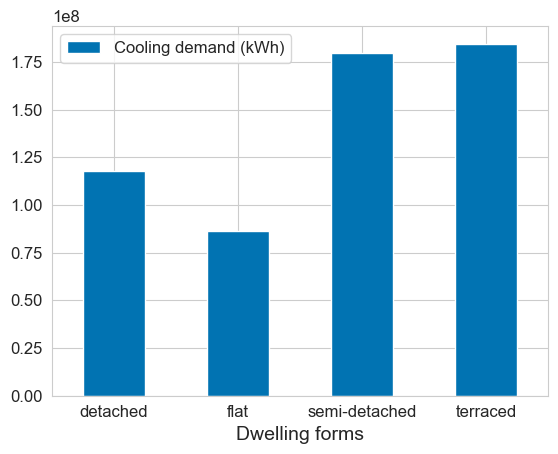

In [61]:
(-temp_concat_results.groupby("Dwelling forms").agg({schema.ResultSchema.COOLINGDEMAND:"sum"})).plot.bar(rot=0)

<AxesSubplot: xlabel='Dwelling forms'>

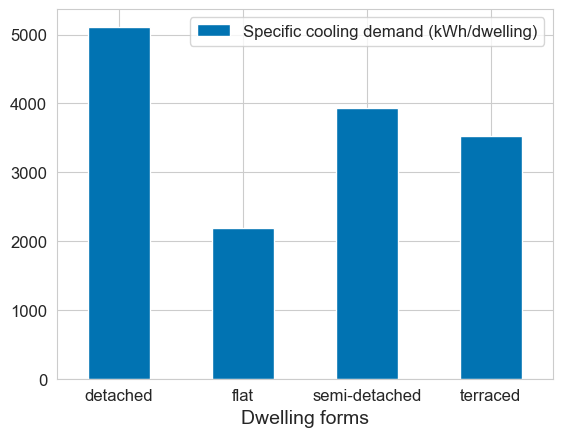

In [62]:
(-temp_concat_results.groupby("Dwelling forms").agg({schema.ResultSchema.SPECIFICCOOLINGDEMAND:"mean"})).plot.bar(rot=0)

In [63]:
temp_LA_results[schema.ResultSchema.COOLINGDEMAND].sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of Index
406262   -1.339114e+05
406263   -1.603125e+04
406264   -1.787070e+05
406265   -6.836636e+03
406266   -1.952704e+06
              ...     
408488   -2.935799e+03
408489   -2.016188e+05
408490   -2.493368e+03
408491   -2.496658e+05
408492   -1.425039e+05
Name: Cooling demand (kWh), Length: 1737, dtype: float64>